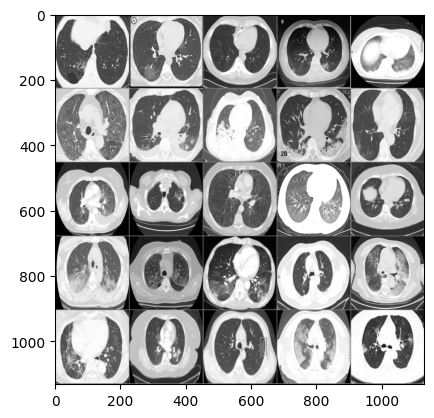

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold

# Device configuration
device = torch.device('cpu')

# Configuration options
k_folds = 5
num_epochs = 50
batch_size = 100
learning_rate = 0.001

# Define a custom transformation to convert RGB to grayscale
class RGBtoGray:
    def __call__(self, img):
        # Convert the PIL Image to grayscale
        gray_img = img.convert('L')
        return gray_img

# transform
transform = transforms.Compose(
    [RGBtoGray(),
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

train_dataset=torchvision.datasets.ImageFolder(root='../COVID-19-Lung-CT-Scans-Classification-CNN/Data_dir/train data', transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root='../COVID-19-Lung-CT-Scans-Classification-CNN/Data_dir/test data', transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

classes = ('CT_COVID', 'CT_NonCOVID')

def imshow(imgs):
    imgs = imgs / 2 + 0.5     # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))  
    plt.show()

# one batch of random training images
# Iterate through the batches in the DataLoader
for images, labels in train_loader:
    img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
    imshow(img_grid)
    break  # Display images from the first batch and then exit the loop


In [2]:
print(device)

cpu


In [3]:
from tqdm.notebook import tqdm

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.fc1 = nn.Linear(in_features=1024*1*1, out_features=512)
        
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=2)
        
        
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = self.layer5(out)
        # print(out.shape)
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        out = self.fc1(out)
        # print(out.shape)
        out = self.fc2(out)
        # print(out.shape)
        out = self.fc3(out)
        # print(out.shape)
        return out


def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [4]:
from sklearn.metrics import f1_score
from torch.utils.data import ConcatDataset
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score



# For fold results
results = {"accuracy": [], "f1_score": [], "precision" :[],"recall": [], "history": []}

# Set fixed random number seed
torch.manual_seed(42)

dataset = ConcatDataset([train_dataset, test_dataset])

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    # print the size of test and train data
    print(f'Train IDs: {len(train_ids)} | Test IDs: {len(test_ids)}')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=test_subsampler)

    # Init the neural network
    model = ConvNet().to(device)
    model.apply(reset_weights)

    # Initialize optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to store the training and test history
    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []

    # Run the training loop for defined number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for i, (images, labels) in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training accuracy and loss
        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(trainloader)

        # Testing loop (to calculate test loss and accuracy)
        model.eval()  # Set the model to evaluation mode
        correct_test = 0
        total_test = 0
        test_running_loss = 0.0

        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        # Calculate test accuracy and loss
        test_accuracy = 100 * correct_test / total_test
        test_loss = test_running_loss / len(testloader)

        # Append to the history lists
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(model.state_dict(), save_path)

    # Get predictions for the test data
    y_pred = []
    y_true = []

    with torch.no_grad():
        n_correct = 0
        n_samples = len(test_ids)

        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # value, index
            _, predictions = torch.max(outputs, 1)
            n_correct += (predictions == labels).sum().item()
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the {n_samples} test images: {acc} %')
        # Calculate the F1 Score
        f1 = f1_score(y_true, y_pred, average='macro')
        print(f'The F1 Score is {f1:.3f}')
        # Calculate precision and recall
        precision = precision_score(y_true, y_pred, average='macro',zero_division=0)  # Change 'macro' to 'micro' or 'weighted' as needed
        recall = recall_score(y_true, y_pred, average='macro',zero_division=0)  # Change 'macro' to 'micro' or 'weighted' as needed

        # Save results per fold
        results["accuracy"].append(acc)
        results["f1_score"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["history"].append({
            "train_loss": train_loss_history,
            "train_acc": train_accuracy_history,
            "test_loss": test_loss_history,
            "test_acc": test_accuracy_history
        })

# Process is complete.
print('Training process has finished.')

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
avg_acc = sum(results["accuracy"]) / k_folds
avg_f1 = sum(results["f1_score"]) / k_folds
avg_precision = sum(results["precision"]) / k_folds
avg_recall = sum(results["recall"]) / k_folds
print(f'Average model accuracy: {avg_acc:.2f} %')
print(f'Average F1 Score: {avg_f1:.3f}')
print(f'Average precision score: {avg_precision:.3f}')
print(f'Average recall score: {avg_recall:.3f}')


--------------------------------
FOLD 0
--------------------------------
Train IDs: 596 | Test IDs: 150
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=2, bias=True)


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.7990, Train Accuracy: 49.16%, Test Loss: 0.6903, Test Accuracy: 53.33%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.6913, Train Accuracy: 53.19%, Test Loss: 0.6829, Test Accuracy: 53.33%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.6832, Train Accuracy: 53.19%, Test Loss: 0.6613, Test Accuracy: 57.33%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.6642, Train Accuracy: 61.58%, Test Loss: 0.6290, Test Accuracy: 64.00%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6404, Train Accuracy: 67.62%, Test Loss: 0.6026, Test Accuracy: 65.33%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6531, Train Accuracy: 62.75%, Test Loss: 0.6740, Test Accuracy: 61.33%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.6280, Train Accuracy: 66.95%, Test Loss: 0.6451, Test Accuracy: 68.00%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.6197, Train Accuracy: 66.78%, Test Loss: 0.6184, Test Accuracy: 66.67%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.5806, Train Accuracy: 68.79%, Test Loss: 0.5705, Test Accuracy: 68.00%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.5420, Train Accuracy: 72.15%, Test Loss: 0.5180, Test Accuracy: 74.00%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.4899, Train Accuracy: 75.67%, Test Loss: 0.4794, Test Accuracy: 78.00%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.4428, Train Accuracy: 78.19%, Test Loss: 0.6417, Test Accuracy: 72.00%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.5082, Train Accuracy: 76.68%, Test Loss: 0.5560, Test Accuracy: 70.67%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.4943, Train Accuracy: 74.16%, Test Loss: 0.4770, Test Accuracy: 77.33%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.4047, Train Accuracy: 80.54%, Test Loss: 0.4493, Test Accuracy: 78.00%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.3373, Train Accuracy: 85.40%, Test Loss: 0.4735, Test Accuracy: 76.00%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.3213, Train Accuracy: 85.57%, Test Loss: 0.6974, Test Accuracy: 72.00%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.3160, Train Accuracy: 85.23%, Test Loss: 0.5067, Test Accuracy: 80.00%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.2350, Train Accuracy: 90.94%, Test Loss: 0.4219, Test Accuracy: 82.67%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.1720, Train Accuracy: 92.45%, Test Loss: 0.6392, Test Accuracy: 79.33%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.1614, Train Accuracy: 93.12%, Test Loss: 0.7313, Test Accuracy: 77.33%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.0930, Train Accuracy: 96.14%, Test Loss: 0.6716, Test Accuracy: 78.67%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0502, Train Accuracy: 98.49%, Test Loss: 0.7491, Test Accuracy: 80.67%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0467, Train Accuracy: 98.15%, Test Loss: 0.9518, Test Accuracy: 72.67%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.1494, Train Accuracy: 93.96%, Test Loss: 1.4069, Test Accuracy: 72.00%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.0993, Train Accuracy: 96.31%, Test Loss: 0.6933, Test Accuracy: 82.00%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0640, Train Accuracy: 97.15%, Test Loss: 0.7212, Test Accuracy: 79.33%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0287, Train Accuracy: 99.50%, Test Loss: 0.7381, Test Accuracy: 80.67%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0119, Train Accuracy: 100.00%, Test Loss: 0.9671, Test Accuracy: 80.00%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0048, Train Accuracy: 100.00%, Test Loss: 1.0484, Test Accuracy: 80.00%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0023, Train Accuracy: 100.00%, Test Loss: 1.1539, Test Accuracy: 80.67%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0015, Train Accuracy: 100.00%, Test Loss: 1.3510, Test Accuracy: 80.67%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0011, Train Accuracy: 100.00%, Test Loss: 1.1598, Test Accuracy: 80.00%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0004, Train Accuracy: 100.00%, Test Loss: 1.1681, Test Accuracy: 80.00%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0004, Train Accuracy: 100.00%, Test Loss: 1.5091, Test Accuracy: 80.67%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.3707, Test Accuracy: 79.33%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.2476, Test Accuracy: 79.33%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.5148, Test Accuracy: 78.67%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.4439, Test Accuracy: 79.33%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.3075, Test Accuracy: 80.00%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.3845, Test Accuracy: 80.00%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.4299, Test Accuracy: 80.00%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.4745, Test Accuracy: 78.67%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.3940, Test Accuracy: 78.67%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.4772, Test Accuracy: 78.67%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.7334, Test Accuracy: 78.67%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.4265, Test Accuracy: 78.67%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.5672, Test Accuracy: 78.67%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.4803, Test Accuracy: 78.67%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.3404, Test Accuracy: 78.67%
Starting testing
Accuracy of the network on the 150 test images: 78.66666666666667 %
The F1 Score is 0.785
FOLD 1
--------------------------------
Train IDs: 597 | Test IDs: 149
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset train

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.7826, Train Accuracy: 53.77%, Test Loss: 0.6925, Test Accuracy: 51.01%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.6900, Train Accuracy: 52.76%, Test Loss: 0.6869, Test Accuracy: 51.01%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.6828, Train Accuracy: 55.95%, Test Loss: 0.7132, Test Accuracy: 51.01%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.6880, Train Accuracy: 54.27%, Test Loss: 0.6563, Test Accuracy: 61.07%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6704, Train Accuracy: 60.64%, Test Loss: 0.6366, Test Accuracy: 69.80%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6371, Train Accuracy: 67.00%, Test Loss: 0.6014, Test Accuracy: 71.81%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.6117, Train Accuracy: 68.68%, Test Loss: 0.5659, Test Accuracy: 71.81%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.5808, Train Accuracy: 71.69%, Test Loss: 0.6094, Test Accuracy: 69.13%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.5871, Train Accuracy: 72.03%, Test Loss: 0.5850, Test Accuracy: 69.80%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.5497, Train Accuracy: 71.86%, Test Loss: 0.5268, Test Accuracy: 70.47%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.5400, Train Accuracy: 73.70%, Test Loss: 0.5116, Test Accuracy: 72.48%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.5084, Train Accuracy: 75.04%, Test Loss: 0.4890, Test Accuracy: 75.84%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.4581, Train Accuracy: 79.73%, Test Loss: 0.5340, Test Accuracy: 75.17%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.4278, Train Accuracy: 80.40%, Test Loss: 0.4348, Test Accuracy: 80.54%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.4115, Train Accuracy: 81.41%, Test Loss: 0.4411, Test Accuracy: 83.22%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.3403, Train Accuracy: 84.76%, Test Loss: 0.4215, Test Accuracy: 83.89%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.2682, Train Accuracy: 89.11%, Test Loss: 0.5231, Test Accuracy: 83.22%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.2172, Train Accuracy: 91.79%, Test Loss: 0.4649, Test Accuracy: 83.89%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.1764, Train Accuracy: 93.80%, Test Loss: 0.5984, Test Accuracy: 81.88%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.0956, Train Accuracy: 95.31%, Test Loss: 0.5121, Test Accuracy: 83.22%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.0833, Train Accuracy: 97.15%, Test Loss: 0.6526, Test Accuracy: 85.23%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.0614, Train Accuracy: 97.82%, Test Loss: 0.5802, Test Accuracy: 81.21%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0245, Train Accuracy: 99.16%, Test Loss: 0.9055, Test Accuracy: 85.23%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.1599, Train Accuracy: 94.30%, Test Loss: 0.7275, Test Accuracy: 82.55%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.1764, Train Accuracy: 92.96%, Test Loss: 0.5554, Test Accuracy: 79.87%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.1231, Train Accuracy: 94.30%, Test Loss: 0.5535, Test Accuracy: 83.89%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0688, Train Accuracy: 97.49%, Test Loss: 0.5356, Test Accuracy: 86.58%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0494, Train Accuracy: 98.66%, Test Loss: 0.5313, Test Accuracy: 83.89%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0166, Train Accuracy: 99.50%, Test Loss: 0.7423, Test Accuracy: 88.59%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0248, Train Accuracy: 99.33%, Test Loss: 0.7593, Test Accuracy: 86.58%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0157, Train Accuracy: 99.33%, Test Loss: 1.3060, Test Accuracy: 81.21%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0062, Train Accuracy: 99.83%, Test Loss: 0.8514, Test Accuracy: 81.88%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0162, Train Accuracy: 99.66%, Test Loss: 1.1650, Test Accuracy: 84.56%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0136, Train Accuracy: 99.66%, Test Loss: 1.1018, Test Accuracy: 83.89%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0142, Train Accuracy: 99.83%, Test Loss: 0.8653, Test Accuracy: 83.89%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0055, Train Accuracy: 99.66%, Test Loss: 0.9427, Test Accuracy: 83.89%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0056, Train Accuracy: 99.83%, Test Loss: 0.7182, Test Accuracy: 83.89%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0039, Train Accuracy: 99.83%, Test Loss: 1.0226, Test Accuracy: 85.91%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0022, Train Accuracy: 100.00%, Test Loss: 1.2707, Test Accuracy: 85.91%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0012, Train Accuracy: 100.00%, Test Loss: 0.9435, Test Accuracy: 84.56%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0003, Train Accuracy: 100.00%, Test Loss: 0.9474, Test Accuracy: 85.91%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 0.8631, Test Accuracy: 85.91%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.8629, Test Accuracy: 85.23%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.1147, Test Accuracy: 85.23%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.9864, Test Accuracy: 85.23%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.1281, Test Accuracy: 85.23%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.9910, Test Accuracy: 85.23%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.0096, Test Accuracy: 85.23%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.1631, Test Accuracy: 85.91%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.0870, Test Accuracy: 85.91%
Starting testing
Accuracy of the network on the 149 test images: 85.90604026845638 %
The F1 Score is 0.859
FOLD 2
--------------------------------
Train IDs: 597 | Test IDs: 149
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset train

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.7162, Train Accuracy: 54.27%, Test Loss: 0.6840, Test Accuracy: 59.73%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.6925, Train Accuracy: 51.59%, Test Loss: 0.6805, Test Accuracy: 59.73%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.6851, Train Accuracy: 55.44%, Test Loss: 0.6534, Test Accuracy: 61.07%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.6752, Train Accuracy: 55.44%, Test Loss: 0.6992, Test Accuracy: 40.94%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6884, Train Accuracy: 50.08%, Test Loss: 0.6908, Test Accuracy: 58.39%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6824, Train Accuracy: 67.84%, Test Loss: 0.6882, Test Accuracy: 51.68%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.6592, Train Accuracy: 60.64%, Test Loss: 0.6397, Test Accuracy: 67.79%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.6556, Train Accuracy: 65.49%, Test Loss: 0.7512, Test Accuracy: 55.70%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.6735, Train Accuracy: 59.30%, Test Loss: 0.6646, Test Accuracy: 59.73%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.6833, Train Accuracy: 51.76%, Test Loss: 0.6649, Test Accuracy: 62.42%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.6381, Train Accuracy: 66.16%, Test Loss: 0.6406, Test Accuracy: 67.79%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.5721, Train Accuracy: 68.84%, Test Loss: 0.6456, Test Accuracy: 67.79%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.5791, Train Accuracy: 70.69%, Test Loss: 0.6072, Test Accuracy: 70.47%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.5337, Train Accuracy: 71.69%, Test Loss: 0.7325, Test Accuracy: 61.74%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.5460, Train Accuracy: 73.03%, Test Loss: 0.5851, Test Accuracy: 71.81%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.4779, Train Accuracy: 77.72%, Test Loss: 0.5459, Test Accuracy: 75.17%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.5013, Train Accuracy: 75.54%, Test Loss: 0.6267, Test Accuracy: 69.80%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.4849, Train Accuracy: 75.88%, Test Loss: 0.5774, Test Accuracy: 74.50%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.4490, Train Accuracy: 78.56%, Test Loss: 0.5769, Test Accuracy: 71.81%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.4100, Train Accuracy: 80.07%, Test Loss: 0.5491, Test Accuracy: 75.17%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.3835, Train Accuracy: 83.25%, Test Loss: 0.5444, Test Accuracy: 75.84%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.3100, Train Accuracy: 86.77%, Test Loss: 0.5186, Test Accuracy: 76.51%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.2956, Train Accuracy: 87.77%, Test Loss: 0.5786, Test Accuracy: 79.19%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.2184, Train Accuracy: 92.13%, Test Loss: 0.5456, Test Accuracy: 75.84%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.1927, Train Accuracy: 91.79%, Test Loss: 0.5531, Test Accuracy: 81.88%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.1526, Train Accuracy: 94.14%, Test Loss: 0.5275, Test Accuracy: 79.19%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0946, Train Accuracy: 96.31%, Test Loss: 0.7506, Test Accuracy: 76.51%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.1401, Train Accuracy: 93.80%, Test Loss: 0.6597, Test Accuracy: 80.54%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0930, Train Accuracy: 96.82%, Test Loss: 0.7671, Test Accuracy: 77.18%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0629, Train Accuracy: 97.99%, Test Loss: 1.0144, Test Accuracy: 79.19%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0372, Train Accuracy: 98.83%, Test Loss: 1.0406, Test Accuracy: 77.85%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0190, Train Accuracy: 99.50%, Test Loss: 1.2333, Test Accuracy: 76.51%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0072, Train Accuracy: 100.00%, Test Loss: 1.2387, Test Accuracy: 79.87%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0045, Train Accuracy: 100.00%, Test Loss: 1.3815, Test Accuracy: 78.52%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0109, Train Accuracy: 99.50%, Test Loss: 1.4328, Test Accuracy: 78.52%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0225, Train Accuracy: 99.16%, Test Loss: 1.6824, Test Accuracy: 81.21%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0204, Train Accuracy: 99.16%, Test Loss: 1.3417, Test Accuracy: 76.51%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0185, Train Accuracy: 99.50%, Test Loss: 1.4781, Test Accuracy: 81.21%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0124, Train Accuracy: 99.66%, Test Loss: 2.2554, Test Accuracy: 77.18%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.1072, Train Accuracy: 96.82%, Test Loss: 1.3577, Test Accuracy: 80.54%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0337, Train Accuracy: 99.16%, Test Loss: 1.2847, Test Accuracy: 80.54%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0178, Train Accuracy: 99.33%, Test Loss: 1.5990, Test Accuracy: 80.54%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0219, Train Accuracy: 99.33%, Test Loss: 1.5521, Test Accuracy: 78.52%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0151, Train Accuracy: 99.50%, Test Loss: 1.8115, Test Accuracy: 77.18%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0059, Train Accuracy: 100.00%, Test Loss: 1.6215, Test Accuracy: 79.87%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0036, Train Accuracy: 99.83%, Test Loss: 1.5125, Test Accuracy: 79.87%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0015, Train Accuracy: 100.00%, Test Loss: 1.5421, Test Accuracy: 79.19%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0005, Train Accuracy: 100.00%, Test Loss: 1.8107, Test Accuracy: 82.55%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0005, Train Accuracy: 100.00%, Test Loss: 1.5269, Test Accuracy: 81.21%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.7933, Test Accuracy: 80.54%
Starting testing
Accuracy of the network on the 149 test images: 80.53691275167785 %
The F1 Score is 0.799
FOLD 3
--------------------------------
Train IDs: 597 | Test IDs: 149
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset train

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.7238, Train Accuracy: 51.42%, Test Loss: 0.6941, Test Accuracy: 49.66%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.6915, Train Accuracy: 54.10%, Test Loss: 0.6955, Test Accuracy: 49.66%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.6876, Train Accuracy: 54.10%, Test Loss: 0.7048, Test Accuracy: 49.66%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.6848, Train Accuracy: 52.60%, Test Loss: 0.6858, Test Accuracy: 68.46%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6667, Train Accuracy: 57.29%, Test Loss: 0.7156, Test Accuracy: 49.66%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6414, Train Accuracy: 62.48%, Test Loss: 0.5999, Test Accuracy: 68.46%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.6399, Train Accuracy: 66.33%, Test Loss: 0.6523, Test Accuracy: 61.74%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.6480, Train Accuracy: 58.79%, Test Loss: 0.6546, Test Accuracy: 63.09%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.6159, Train Accuracy: 69.01%, Test Loss: 0.5944, Test Accuracy: 67.79%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.5813, Train Accuracy: 69.51%, Test Loss: 0.5478, Test Accuracy: 69.13%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.5214, Train Accuracy: 74.04%, Test Loss: 0.5628, Test Accuracy: 69.13%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.4905, Train Accuracy: 74.87%, Test Loss: 0.5306, Test Accuracy: 75.17%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.4993, Train Accuracy: 76.05%, Test Loss: 0.4899, Test Accuracy: 73.83%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.4400, Train Accuracy: 79.56%, Test Loss: 0.4900, Test Accuracy: 77.18%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.3882, Train Accuracy: 83.08%, Test Loss: 0.5038, Test Accuracy: 74.50%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.3725, Train Accuracy: 83.25%, Test Loss: 0.5390, Test Accuracy: 77.18%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.3777, Train Accuracy: 82.75%, Test Loss: 0.5309, Test Accuracy: 76.51%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.3163, Train Accuracy: 85.26%, Test Loss: 0.5491, Test Accuracy: 77.85%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.2594, Train Accuracy: 88.78%, Test Loss: 0.6573, Test Accuracy: 71.81%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.2697, Train Accuracy: 87.94%, Test Loss: 0.7742, Test Accuracy: 76.51%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.2172, Train Accuracy: 91.79%, Test Loss: 0.4726, Test Accuracy: 81.88%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.1192, Train Accuracy: 95.64%, Test Loss: 0.6343, Test Accuracy: 79.87%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0877, Train Accuracy: 96.82%, Test Loss: 0.8118, Test Accuracy: 79.19%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.1372, Train Accuracy: 93.80%, Test Loss: 0.7003, Test Accuracy: 80.54%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.1000, Train Accuracy: 96.48%, Test Loss: 0.7546, Test Accuracy: 78.52%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.1056, Train Accuracy: 96.15%, Test Loss: 0.6139, Test Accuracy: 77.85%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0558, Train Accuracy: 98.32%, Test Loss: 0.9523, Test Accuracy: 75.17%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0377, Train Accuracy: 98.66%, Test Loss: 0.7999, Test Accuracy: 79.19%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0232, Train Accuracy: 99.50%, Test Loss: 1.0615, Test Accuracy: 78.52%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0163, Train Accuracy: 99.66%, Test Loss: 1.0291, Test Accuracy: 78.52%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0037, Train Accuracy: 100.00%, Test Loss: 1.2263, Test Accuracy: 80.54%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0092, Train Accuracy: 99.66%, Test Loss: 1.1107, Test Accuracy: 79.87%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0008, Train Accuracy: 100.00%, Test Loss: 1.4642, Test Accuracy: 78.52%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0038, Train Accuracy: 99.83%, Test Loss: 1.3943, Test Accuracy: 78.52%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0109, Train Accuracy: 99.83%, Test Loss: 1.3770, Test Accuracy: 79.19%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0088, Train Accuracy: 99.83%, Test Loss: 1.4906, Test Accuracy: 75.84%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0095, Train Accuracy: 99.50%, Test Loss: 1.3112, Test Accuracy: 81.21%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0067, Train Accuracy: 99.83%, Test Loss: 1.0861, Test Accuracy: 75.84%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0024, Train Accuracy: 99.83%, Test Loss: 1.3063, Test Accuracy: 77.18%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0003, Train Accuracy: 100.00%, Test Loss: 1.4254, Test Accuracy: 78.52%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 1.3334, Test Accuracy: 79.19%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.4178, Test Accuracy: 79.19%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.4384, Test Accuracy: 79.19%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.4516, Test Accuracy: 79.19%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.3971, Test Accuracy: 78.52%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.5095, Test Accuracy: 78.52%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.5820, Test Accuracy: 79.19%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.2906, Test Accuracy: 79.19%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.5230, Test Accuracy: 79.87%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.4675, Test Accuracy: 79.19%
Starting testing
Accuracy of the network on the 149 test images: 79.19463087248322 %
The F1 Score is 0.792
FOLD 4
--------------------------------
Train IDs: 597 | Test IDs: 149
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset train

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.8499, Train Accuracy: 50.08%, Test Loss: 0.6920, Test Accuracy: 52.35%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.6912, Train Accuracy: 53.43%, Test Loss: 0.6881, Test Accuracy: 52.35%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.6738, Train Accuracy: 53.43%, Test Loss: 0.6514, Test Accuracy: 52.35%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.6495, Train Accuracy: 62.81%, Test Loss: 0.7374, Test Accuracy: 53.69%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6448, Train Accuracy: 62.65%, Test Loss: 0.6658, Test Accuracy: 55.70%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6157, Train Accuracy: 70.18%, Test Loss: 0.6688, Test Accuracy: 63.76%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.5775, Train Accuracy: 70.52%, Test Loss: 0.6859, Test Accuracy: 60.40%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.6022, Train Accuracy: 68.01%, Test Loss: 0.6152, Test Accuracy: 69.13%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.5685, Train Accuracy: 72.03%, Test Loss: 0.6002, Test Accuracy: 67.11%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.5469, Train Accuracy: 72.70%, Test Loss: 0.7029, Test Accuracy: 61.74%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.5377, Train Accuracy: 74.04%, Test Loss: 0.6649, Test Accuracy: 65.77%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.5526, Train Accuracy: 72.70%, Test Loss: 0.5502, Test Accuracy: 69.13%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.4989, Train Accuracy: 77.72%, Test Loss: 0.6678, Test Accuracy: 69.13%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.5350, Train Accuracy: 72.53%, Test Loss: 0.5196, Test Accuracy: 77.18%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.4918, Train Accuracy: 77.22%, Test Loss: 0.5056, Test Accuracy: 73.15%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.4541, Train Accuracy: 80.74%, Test Loss: 0.6610, Test Accuracy: 68.46%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.4408, Train Accuracy: 78.22%, Test Loss: 0.5274, Test Accuracy: 72.48%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.3901, Train Accuracy: 81.74%, Test Loss: 0.5115, Test Accuracy: 73.15%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.3044, Train Accuracy: 85.43%, Test Loss: 0.3854, Test Accuracy: 80.54%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.2197, Train Accuracy: 91.79%, Test Loss: 0.4265, Test Accuracy: 82.55%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.1869, Train Accuracy: 93.30%, Test Loss: 0.4001, Test Accuracy: 84.56%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.1280, Train Accuracy: 94.64%, Test Loss: 0.5225, Test Accuracy: 83.22%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0919, Train Accuracy: 96.82%, Test Loss: 0.4767, Test Accuracy: 83.89%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0538, Train Accuracy: 97.65%, Test Loss: 0.7275, Test Accuracy: 82.55%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.0445, Train Accuracy: 98.49%, Test Loss: 0.5739, Test Accuracy: 85.91%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.0228, Train Accuracy: 99.33%, Test Loss: 0.8881, Test Accuracy: 82.55%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0196, Train Accuracy: 99.33%, Test Loss: 0.7016, Test Accuracy: 83.22%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0532, Train Accuracy: 98.16%, Test Loss: 0.6713, Test Accuracy: 83.89%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0322, Train Accuracy: 98.49%, Test Loss: 1.1644, Test Accuracy: 79.87%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0460, Train Accuracy: 98.16%, Test Loss: 1.0744, Test Accuracy: 80.54%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0184, Train Accuracy: 99.33%, Test Loss: 0.9013, Test Accuracy: 79.87%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0412, Train Accuracy: 98.32%, Test Loss: 1.0082, Test Accuracy: 83.22%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0653, Train Accuracy: 97.82%, Test Loss: 1.1905, Test Accuracy: 79.19%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0771, Train Accuracy: 97.49%, Test Loss: 0.7402, Test Accuracy: 81.88%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0470, Train Accuracy: 97.99%, Test Loss: 0.6926, Test Accuracy: 84.56%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0088, Train Accuracy: 100.00%, Test Loss: 0.7749, Test Accuracy: 85.23%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0051, Train Accuracy: 100.00%, Test Loss: 0.8814, Test Accuracy: 83.89%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0023, Train Accuracy: 100.00%, Test Loss: 0.8443, Test Accuracy: 85.91%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0010, Train Accuracy: 100.00%, Test Loss: 0.8225, Test Accuracy: 87.25%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0004, Train Accuracy: 100.00%, Test Loss: 0.8857, Test Accuracy: 86.58%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 0.8504, Test Accuracy: 87.25%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.8602, Test Accuracy: 87.25%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.8540, Test Accuracy: 87.25%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.9631, Test Accuracy: 87.25%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.8169, Test Accuracy: 87.25%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.1187, Test Accuracy: 87.25%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 0.9130, Test Accuracy: 86.58%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.0973, Test Accuracy: 86.58%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 1.0186, Test Accuracy: 87.25%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 0.9314, Test Accuracy: 86.58%
Starting testing
Accuracy of the network on the 149 test images: 86.57718120805369 %
The F1 Score is 0.866
Training process has finished.
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average model accuracy: 82.18 %
Average F1 Score: 0.820
Average precision score: 0.821
Average recall score: 0.821


In [7]:
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
avg_acc = sum(results["accuracy"]) / k_folds
avg_f1 = sum(results["f1_score"]) / k_folds
avg_precision = sum(results["precision"]) / k_folds
avg_recall = sum(results["recall"]) / k_folds
print(f'Average model accuracy: {avg_acc:.2f} %')
print(f'Average F1 Score: {avg_f1:.3f}')
print(f'Average precision score: {avg_precision:.3f}')
print(f'Average recall score: {avg_recall:.3f}')

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average model accuracy: 82.18 %
Average F1 Score: 0.820
Average precision score: 0.821
Average recall score: 0.821


hystory of fold 0


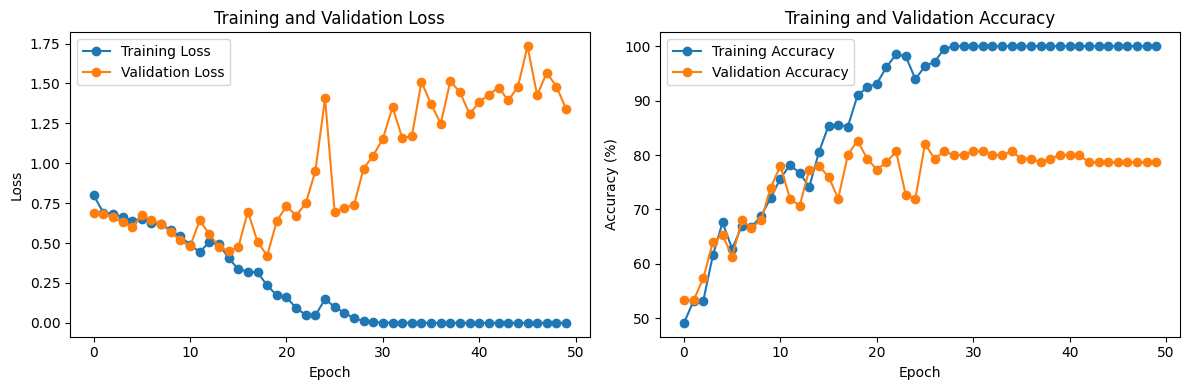

hystory of fold 1


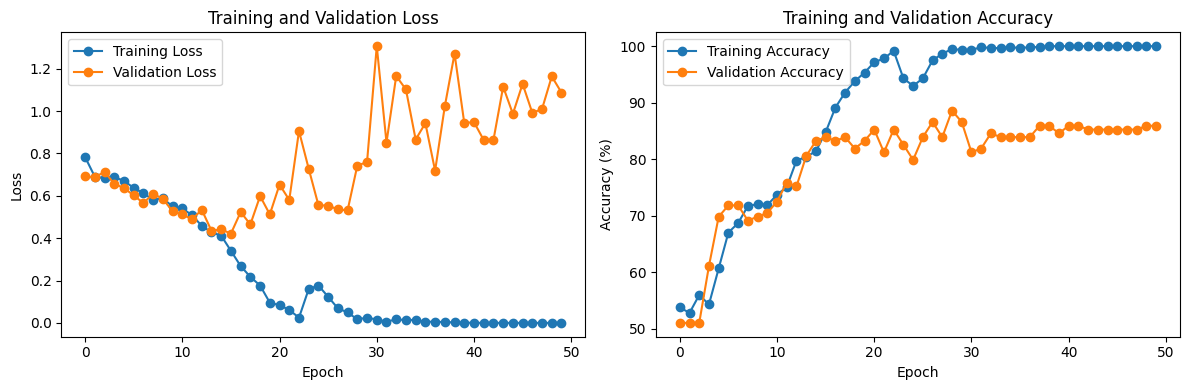

hystory of fold 2


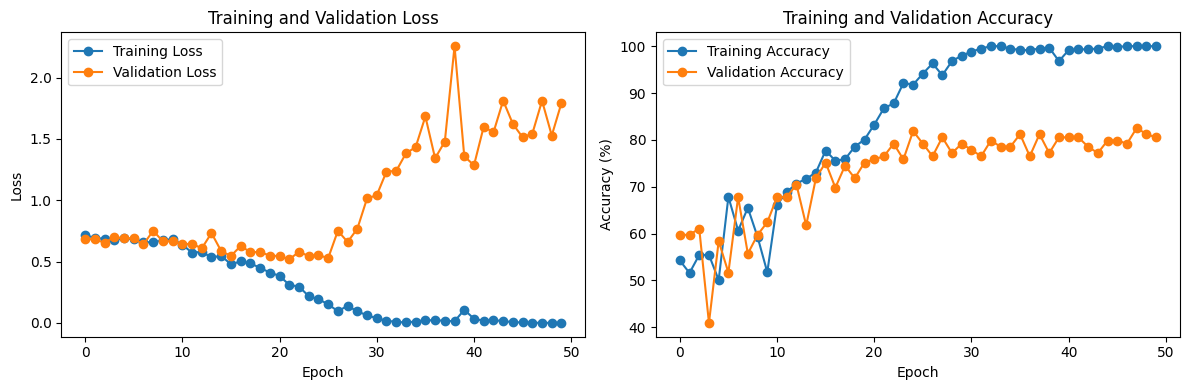

hystory of fold 3


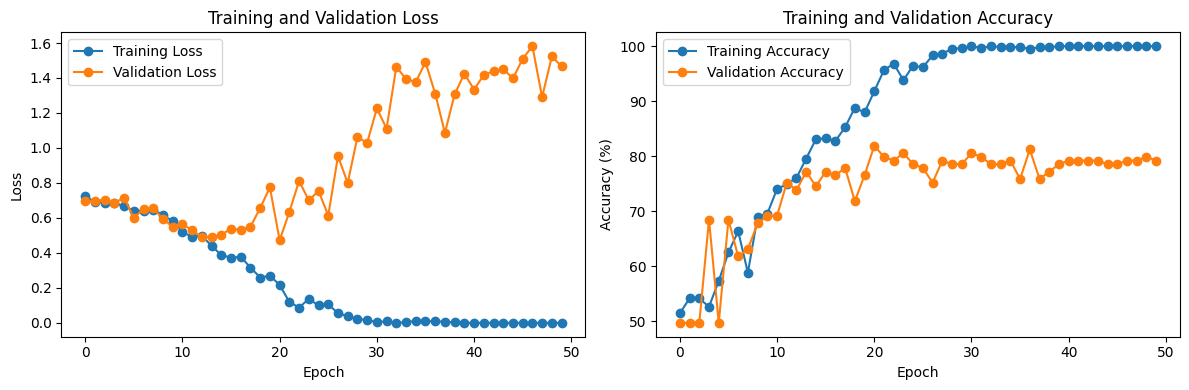

hystory of fold 4


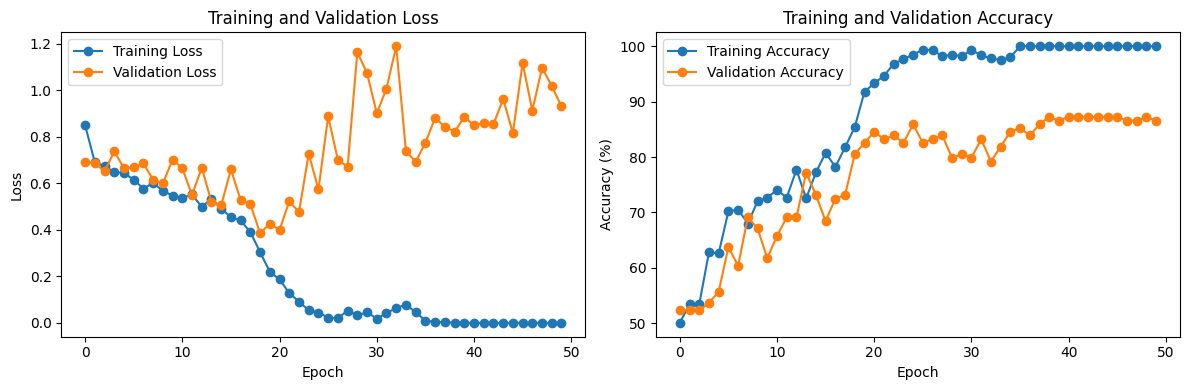

In [5]:
import matplotlib.pyplot as plt

f=0
for history in results["history"]:
    train_loss_history = history["train_loss"]
    train_accuracy_history = history["train_acc"]
    test_loss_history = history["test_loss"]
    test_accuracy_history = history["test_acc"]
    
    print(f'hystory of fold {f}')
    f+=1

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss', marker='o')
    plt.plot(test_loss_history, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, label='Training Accuracy', marker='o')
    plt.plot(test_accuracy_history, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()
